<a href="https://colab.research.google.com/github/prashanthyamala/Tagging-QA-of-stackoverflow-/blob/main/NLP_Increment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

import warnings

import pickle
import time

import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss
from sklearn.cluster import KMeans


import logging

from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

In [ ]:
# Setting a random seed in order to keep the same random results each time I run the notebook
np.random.seed(seed=11)

In [22]:
df_questions = pd.read_csv("/content/Questions.csv", encoding="ISO-8859-1")

In [23]:
df_questions.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [24]:
tags = pd.read_csv("/content/Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [25]:
tags.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [26]:
df_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424250 entries, 0 to 424249
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            424250 non-null  int64  
 1   OwnerUserId   416379 non-null  float64
 2   CreationDate  424250 non-null  object 
 3   ClosedDate    16348 non-null   object 
 4   Score         424250 non-null  int64  
 5   Title         424250 non-null  object 
 6   Body          424249 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 22.7+ MB


In [27]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [28]:
tags['Tag'] = tags['Tag'].astype(str)

In [11]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [12]:
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [13]:

grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [14]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [15]:
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [16]:
df_questions.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

In [17]:
df = df_questions.merge(grouped_tags_final, on='Id')

In [18]:
df.head(5)


,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [20]:
new_df = df[df['Score']>5]

Text(0.5, 1.0, 'Ratio of missing values per columns')

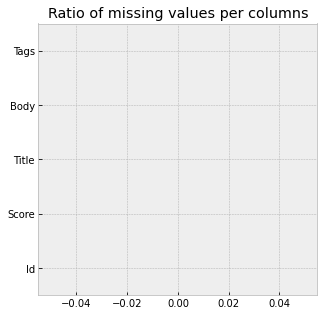

In [29]:
plt.figure(figsize=(5, 5))
new_df.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [30]:
print('Dupplicate entries in the datasets: {}'.format(new_df.duplicated().sum()))
new_df.drop_duplicates(inplace = True)

Dupplicate entries: 0


In [31]:
new_df.drop(columns=['Id', 'Score'], inplace=True)

In [32]:
new_df.head(5)

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


In [33]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: x.split())

In [37]:
whole_tags = [item for sublist in new_df['Tags'].values for item in sublist]

In [38]:
len(whole_tags)

152913

In [40]:
my_set_tags = set(whole_tags)
unique_tags_count = list(my_set_tags)
len(unique_tags_count)

11469

In [41]:
flatten_list = [item for sublist in new_df['Tags'].values for item in sublist]

keywords = nltk.FreqDist(flatten_list)

keywords = nltk.FreqDist(keywords)

frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]

In [42]:
tags_features

['c#',
 'java',
 'javascript',
 'python',
 'c++',
 'android',
 '.net',
 'php',
 'jquery',
 'iphone',
 'html',
 'c',
 'css',
 'objective-c',
 'ios',
 'ruby-on-rails',
 'sql',
 'asp.net',
 'mysql',
 'ruby',
 'asp.net-mvc',
 'sql-server',
 'git',
 'linux',
 'wpf',
 'django',
 'string',
 'algorithm',
 'eclipse',
 'performance',
 'r',
 'windows',
 'arrays',
 'regex',
 'multithreading',
 'database',
 'xcode',
 'xml',
 'visual-studio',
 'scala',
 'json',
 'haskell',
 'unit-testing',
 'osx',
 'bash',
 'html5',
 'visual-studio-2010',
 'ruby-on-rails-3',
 'node.js',
 'delphi',
 'ajax',
 'cocoa-touch',
 'winforms',
 'linq',
 'perl',
 'spring',
 'cocoa',
 'debugging',
 'asp.net-mvc-3',
 'vim',
 'c++11',
 'security',
 'oop',
 'generics',
 'shell',
 'entity-framework',
 'svn',
 'tsql',
 'oracle',
 'image',
 'math',
 'hibernate',
 'http',
 'list',
 'wcf',
 'exception',
 'ipad',
 'templates',
 'facebook',
 'postgresql',
 'swing',
 'emacs',
 'sql-server-2008',
 'gcc',
 'mongodb',
 'design-patterns',
 '

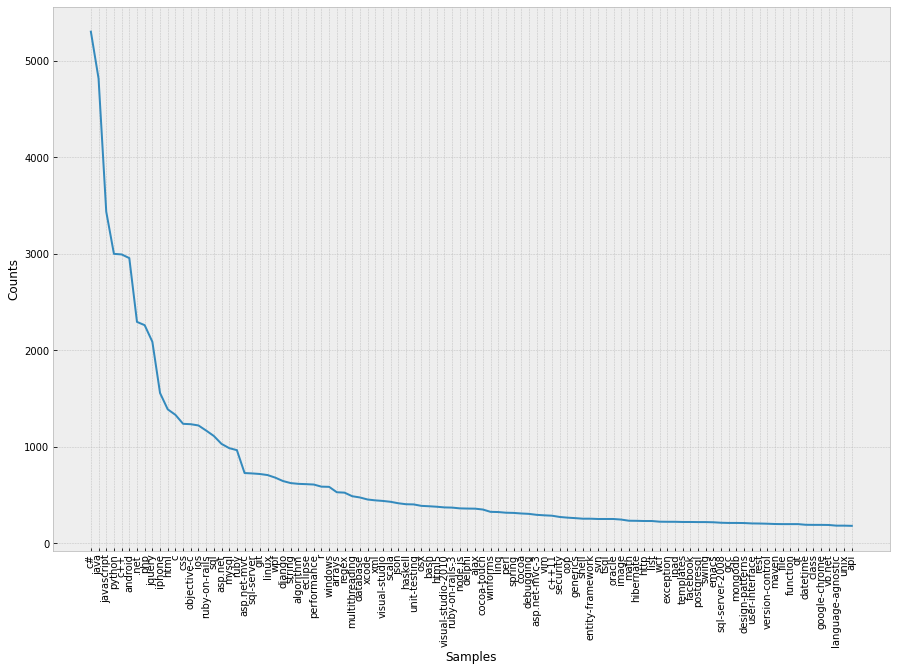

In [43]:
figure, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [44]:
def most_common(tags):
    tags_filtered = []
    for i in range(0, len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [45]:
new_df['Tags'] = new_df['Tags'].apply(lambda x: most_common(x))
new_df['Tags'] = new_df['Tags'].apply(lambda x: x if len(x)>0 else None)

In [46]:
new_df.shape

(50588, 3)

In [47]:
new_df.dropna(subset=['Tags'], inplace=True)

In [48]:
new_df.shape

(44305, 3)

NLP
1. removal of html formats from the dataset
2. performing lowering of text
3. transforming of abbrevations
4. removing all the punctuations
5. words lemmatization 
6. removal of stop words 


In [49]:
# Convertion of html to text in the body

new_df['Body'] = new_df['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [50]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [51]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_text(x)) 

In [52]:
token=ToktokTokenizer()

In [57]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [58]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [59]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [60]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

In [61]:
new_df['Body'] = new_df['Body'].apply(lambda x: clean_punct(x)) 

In [62]:
new_df['Body'][2]

'has anyone got experience creating sql-based asp.net site-map providers i have got the default xml file websitemap working properly with my menu and sitemappath controls but i will need a way for the users of my site to create and modify pages dynamically i need to tie page viewing permissions into the standard asp.net membership system as well'

In [64]:
  import nltk
  nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [65]:
lemma=WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [66]:
def lemitizeWords(text):
    words=token.tokenize(text)
    listLemma=[]
    for w in words:
        x=lemma.lemmatize(w, pos="v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))

def stopWordsRemove(text):
    
    stop_words = set(stopwords.words("english"))
    
    words=token.tokenize(text)
    
    filtered = [w for w in words if not w in stop_words]
    
    return ' '.join(map(str, filtered))

In [115]:
stopWordsRemove("html has a good documentation in tags")

'html good documentation tags'

In [118]:
lemitizeWords("the coding part relating javascript is widely appreciated ")

'the cod part relate javascript be widely appreciate'

In [72]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [73]:
new_df['Body'] = new_df['Body'].apply(lambda x: lemitizeWords(x)) 
new_df['Body'] = new_df['Body'].apply(lambda x: stopWordsRemove(x)) 

LDA 

In [95]:
no_topics = 10

In [91]:
text = new_df['Body']

In [92]:
vectorizer_train = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                       max_features=1000)

In [93]:
TF_IDF_matrix = vectorizer_train.fit_transform(text)

In [99]:
lda = LatentDirichletAllocation(n_components=no_topics,random_state=0).fit(TF_IDF_matrix)

In [100]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")
        

no_top_words = 10
display_topics(lda, vectorizer_train.get_feature_names(), no_top_words)

--------------------------------------------
Topic 0:
image color use size file draw page want css like
--------------------------------------------
--------------------------------------------
Topic 1:
class foo type object function int value use return public
--------------------------------------------
--------------------------------------------
Topic 2:
file project use run git command error directory get try
--------------------------------------------
--------------------------------------------
Topic 3:
table query select sql database row column data value use
--------------------------------------------
--------------------------------------------
Topic 4:
124 int std use number char code function array return
--------------------------------------------
--------------------------------------------
Topic 5:
app application thread android use run user get device iphone
--------------------------------------------
--------------------------------------------
Topic 6:
string arra

classifiers 
1. after pre-processing the dataset by using NLP techniques, now we have built the model
2. Initially, we have binarize the tags 
3. we have to transform the body and title into vector by using TFIDF(term-freqence-inverse-document frequency

In [101]:
body_temp = new_df['Body']
title_temp = new_df['Title']
new_tags = new_df['Tags']

In [102]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(new_tags)

In [103]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [105]:
X1_tfidf = vectorizer_X1.fit_transform(body_temp)
X2_tfidf = vectorizer_X2.fit_transform(title_temp)

In [106]:
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Doing 0.8/0.2 split

In [111]:
def accuracy(y_true, y_pred):
    # Intitializing variable to store count of correctly predicted classes
    correct_predictions = 0
    for yt, yp in zip(y_true, y_pred):
        if yt.all() == yp.all():
            correct_predictions += 1
    #returns accuracy
    return correct_predictions / len(y_true)

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Accuracy score: {}".format(accuracy(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")    


In [112]:

lr = LogisticRegression()
mn = MultinomialNB()
for classifier in [lr, mn]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  LogisticRegression
Accuracy score: 1.0
Hamming loss: 1.040176052364293
---
Clf:  MultinomialNB
Accuracy score: 1.0
Hamming loss: 1.1958018282360907
---
